In [143]:
import nltk
import time


''' 0:hate
    1:offensive
    2:neither'''
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import string


#NLP tools
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

#train split and fit models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

#model selection
from sklearn.metrics import confusion_matrix, accuracy_score

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [35]:
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /Users/Leah/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Leah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
dataset = pd.read_csv('speech.csv')
dataset.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [37]:
dic={0:'Hate',
     1:'Offensive',
     2:'None'}

In [38]:
dataset.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [39]:
dt_transformed = dataset[['class', 'tweet']]
y=dt_transformed['class'].values
print(y)
print(dt_transformed)

[2 1 1 ... 1 1 2]
       class                                              tweet
0          2  !!! RT @mayasolovely: As a woman you shouldn't...
1          1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2          1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3          1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4          1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...      ...                                                ...
24778      1  you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779      2  you've gone and broke the wrong heart baby, an...
24780      1  young buck wanna eat!!.. dat nigguh like I ain...
24781      1              youu got wild bitches tellin you lies
24782      2  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...

[24783 rows x 2 columns]


[Text(0, 0, 'hate'), Text(1, 0, 'offensive'), Text(2, 0, 'None')]

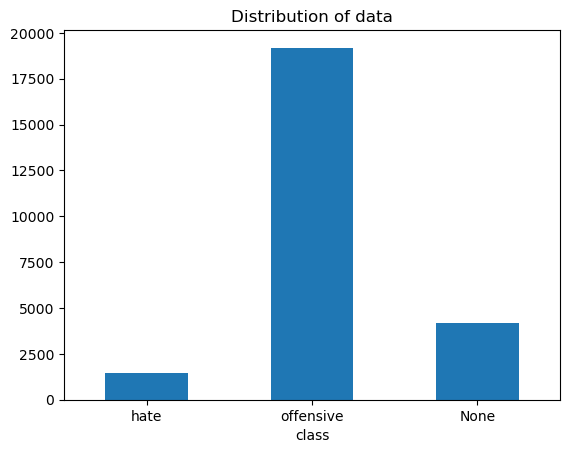

In [40]:
ax = dt_transformed.groupby('class').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['hate','offensive','None'], rotation=0)

In [41]:
#Preprocessing Data

def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    newlinepattern = '\n'
    
     
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace all new line with " "
        tweet = re.sub(newlinepattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
                if len(word)>1:
                    # Lemmatizing the word.
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText


t = time.time()
corpus = preprocess(dt_transformed['tweet'])
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 3 seconds


In [42]:
cv = CountVectorizer(max_features = 2000)
X = cv.fit_transform(corpus).toarray()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [44]:
classifier_lr = LogisticRegression( solver='lbfgs',max_iter=1000,random_state = 0)
classifier_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [48]:
def predict(text):
    # Predict the sentiment
    textdata = cv.transform(preprocess(text)).toarray()
    sentiment = classifier_lr.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['tweet','class'])
    df = df.replace([0,1,2], ["Hate","Offensive","Neither"])
    return df

In [139]:
test_data = ["im busy chill out please"]
result = predict(test_data)
print(result)

                      tweet    class
0  im busy chill out please  Neither


In [140]:
y_pred_lr = classifier_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr)
print(cm)

[[  70  176   33]
 [  74 3675  103]
 [  11   79  736]]


In [142]:
lr_score = accuracy_score(y_test, y_pred_lr)
print('Logistic Regression Accuracy: ', str(lr_score))

Logistic Regression Accuracy:  0.9039741779301997


In [146]:
file = open('speech.pkl', 'wb')
pickle.dump([classifier_lr, cv], open('speech.pkl', 'wb'))